In [55]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from itertools import chain
from sklearn.metrics import classification_report
from collections import Counter


In [56]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10466868708771592792
]
Num GPUs Available:  0


In [57]:
df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "unicode-escape", error_bad_lines=False)
#df = df[:600000]
df = df.fillna(method='ffill')

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


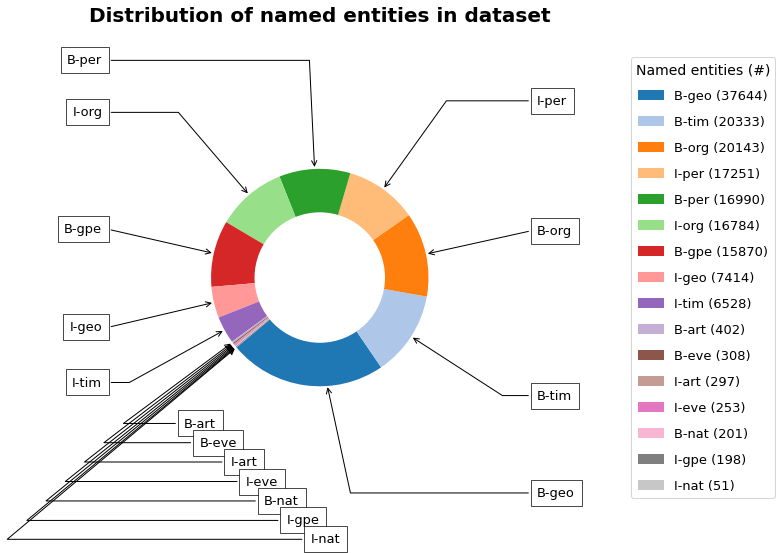

In [58]:
tag_plot = df[df["Tag"]!="O"]["Tag"].value_counts()

#https://matplotlib.org/devdocs/gallery/pie_and_polar_charts/pie_and_donut_labels.html

with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
    fig1 = plt.figure( figsize=[10,5])
    ax1 = fig1.add_subplot(111, aspect='equal')

    wedges, texts = ax1.pie(tag_plot.values, startangle=-140, radius=1)

    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="->"),
          bbox=bbox_props, zorder=0, va="center")

    shift = [0,0,0,0,0,0,0,0,0,10, 20, 30, 40, 50, 60, 70]

    for i, p in enumerate(wedges):

        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        if(i == 0):
            ang = ang + 20
            x = x * -0.5

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})

        if(i < 9):
            ax1.annotate(tag_plot.index[i], xy=(x, y), xytext=(2*np.sign(x), 2*y), size=13,
                    horizontalalignment=horizontalalignment, **kw)

        if(i > 8):
            ax1.annotate(tag_plot.index[i], xy=(x, y), xytext=(-i/7+shift[i]/30, 2*i/8*y), size=13,
                    horizontalalignment=horizontalalignment, **kw)

    
    centre_circle = plt.Circle((0,0),0.60,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    legend_label = []

    for i, x in enumerate(tag_plot):
        legend_label.append(tag_plot.index[i] + " " + "(" + str(tag_plot.values[i]) + ")")

    plt.legend(legend_label,bbox_to_anchor=(2.2,0.5), loc="center right", fontsize=13, title='Named entities (#)', title_fontsize=14, labelspacing = 1)
    plt.title('Distribution of named entities in dataset', fontweight="bold", size=20, pad=120.0)
    plt.show()

In [59]:
#Create mapper for features

tag_vocab = np.unique(df['Tag']).tolist()
tag_vocab = sorted(tag_vocab, key=lambda x : x.split("-")[-1])

word_vocab = np.unique(df['Word']).tolist()
word_vocab.insert(0, '<PAD>')

pos_vocab = np.unique(df['POS']).tolist()
pos_vocab.insert(0, '<PAD>')

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

i_to_pos = {i:pos for  i, pos in enumerate(pos_vocab)}
pos_to_i = {pos:i for  i, pos in enumerate(pos_vocab)}

In [60]:
#Append index columns for words and tags and group dataframe by sentence

df['Word_index'] = df['Word'].map(word_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)
df['POS_index'] = df['POS'].map(pos_to_i)


df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index', 'POS_index'].agg(lambda x: list(x))
df_grouped.head()

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_9032/242215118.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index', 'POS_index'].agg(lambda x: list(x))


,Sentence #,Word,POS,Tag,Word_index,Tag_index,POS_index
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15078, 27701, 20970, 24219, 26435, 33390, 968...","[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, ...","[20, 11, 20, 36, 35, 11, 18, 30, 32, 8, 17, 11..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[8194, 27728, 31034, 33290, 22578, 33465, 2372...","[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[12, 20, 36, 23, 36, 30, 32, 17, 30, 12, 12, 2..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[7599, 24040, 13560, 28906, 26766, 24371, 2485...","[0, 0, 15, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 11...","[17, 20, 18, 33, 12, 20, 11, 8, 18, 12, 17, 2,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[15050, 25893, 16916, 16575, 33180, 24593, 323...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[23, 33, 11, 8, 17, 12, 17, 11, 17, 20, 3]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[15425, 30228, 20255, 8421, 5853, 30958, 14608...","[5, 0, 0, 13, 14, 0, 15, 0, 5, 0, 7, 0, 7, 0, ...","[18, 17, 17, 18, 18, 33, 18, 2, 18, 2, 12, 6, ..."


No handles with labels found to put in legend.


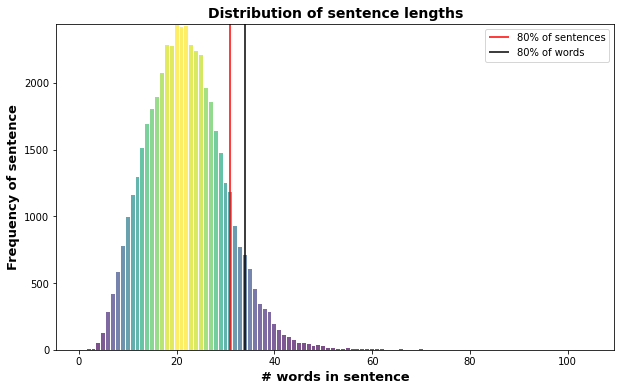

In [61]:
sentence_plot = df_grouped["Word"].values
sentence_plot_sorted = list(sorted(sentence_plot, key=len))
c = Counter(map(len, sentence_plot_sorted))

total_sentences = 0
total_words = 0
for i in c:
    total_sentences = total_sentences + c[i]
    total_words = total_words + c[i]*i

sentences_80_pct = total_sentences / 100 * 90
words_80_pct = total_words / 100 * 90

boundary_sen = 0
counter_sen = 0

for i in c:
    if(counter_sen + c[i] < int(sentences_80_pct)):
        counter_sen = counter_sen + c[i]
        boundary_sen = i
    else:
        break

boundary_word = 0
counter_word = 0

for i in c:
    if(counter_word + c[i] * i < int(words_80_pct)):
        counter_word = counter_word + c[i] * i
        boundary_word = i
    else:
        break


my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=[10,6])
bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

# for r in bars.get_children():
#     if(r.get_x() > boundary_sen):
#         r.set_alpha(0.2)

plt.legend(loc="best")
plt.ylim([0, max(list(c.values()))+10])
ax2 = plt.gca()

ymin, ymax = ax2.get_ylim()
plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
plt.legend()
plt.show()


In [62]:
max_tag = len(tag_vocab)
max_word = len(word_vocab)

tokens = df_grouped['Word_index'].tolist()
tags = df_grouped['Tag_index'].tolist()
pos = df_grouped['POS_index'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post')
pad_pos = pad_sequences(pos, maxlen=max_length, dtype='int32', padding='post')

pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding='post', value= tag_to_i["O"])
n_tags = len(tag_to_i)
pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.4, random_state=42)
#train_pos, test_pos, train_tags, test_tags = train_test_split(pad_pos, pad_tags, test_size=0.4, random_state=42)


In [63]:
input_dim = len(word_vocab)+1
output_dim = 128
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])

In [64]:
root_logdir = os.path.join(os.curdir, "../logged_models/bidir_lstm")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [65]:
#https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54


model = tf.keras.models.Sequential(
    [
        layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, mask_zero=True),
        layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'),
        layers.TimeDistributed(layers.Dense(n_tags, activation="softmax"))
    ]
)

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 128)          4503040   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 104, 256)          263168    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 17)           4369      
Total params: 4,770,577
Trainable params: 4,770,577
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [66]:
#Run in command line
#tensorboard --logdir=C:\Users\Rasmu\Documents\Repos\BAC\Ezra\linguistic\logged_models --port=8888

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(train_tokens, np.array(train_tags), epochs=25, callbacks=[tensorboard_cb, earlystopping, lr_scheduler], validation_split=0.2)
model.save("../saved_models/bidir_lstm.h5")

#model = keras.models.load_model('../saved_models/bidir_lstm.h5')


Epoch 1/25
720/720 [==============================] - 348s 478ms/step - loss: 0.0400 - accuracy: 0.9482 - val_loss: 0.0246 - val_accuracy: 0.9655
Epoch 2/25
720/720 [==============================] - 349s 485ms/step - loss: 0.0167 - accuracy: 0.9746 - val_loss: 0.0239 - val_accuracy: 0.9671
Epoch 3/25
720/720 [==============================] - 373s 517ms/step - loss: 0.0124 - accuracy: 0.9804 - val_loss: 0.0247 - val_accuracy: 0.9671
Epoch 4/25
720/720 [==============================] - 346s 480ms/step - loss: 0.0097 - accuracy: 0.9843 - val_loss: 0.0261 - val_accuracy: 0.9668
Epoch 5/25
720/720 [==============================] - 387s 538ms/step - loss: 0.0077 - accuracy: 0.9873 - val_loss: 0.0276 - val_accuracy: 0.9659
Epoch 6/25
720/720 [==============================] - 423s 587ms/step - loss: 0.0062 - accuracy: 0.9899 - val_loss: 0.0297 - val_accuracy: 0.9658
Epoch 7/25
720/720 [==============================] - 379s 527ms/step - loss: 0.0050 - accuracy: 0.9918 - val_loss: 0.0322 -

In [67]:
y_pred = model.predict(test_tokens) #Calculates probability for each tag

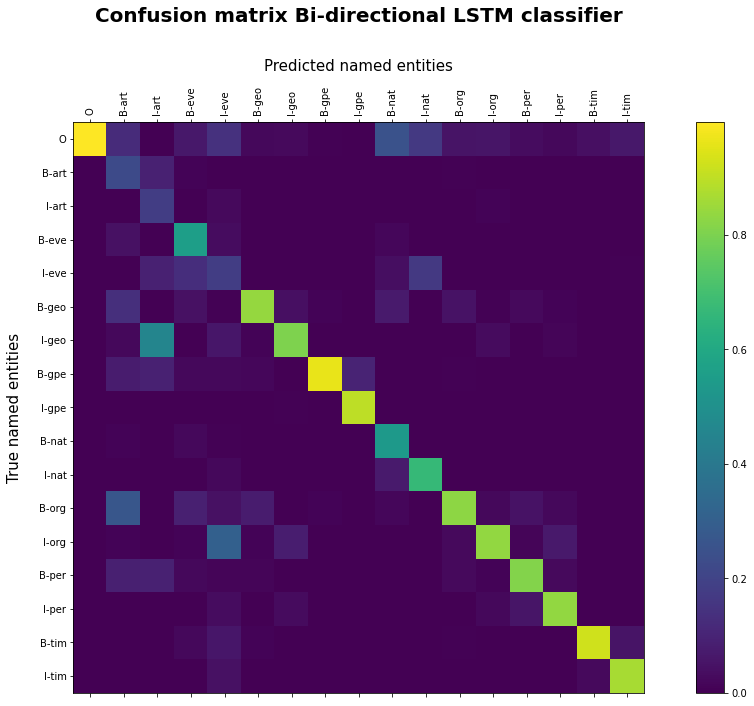

In [72]:
y_classes = y_pred.argmax(axis=-1)

cm_true = np.array(test_tags).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

cm = confusion_matrix(cm_true, cm_pred, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(tag_vocab)), tag_vocab, rotation=90)
plt.yticks(range(len(tag_vocab)), tag_vocab)
plt.show()

In [69]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:17]
df_perf_2.insert(loc=0, column='Tag', value=tag_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Rasmu\AppData\Local\Temp/ipykernel_9032/3817667430.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Tag,precision,recall,f1-score,support
0,O,1.00,1.00,1.00,1931074.0
1,B-art,0.22,0.11,0.15,174.0
2,I-art,0.18,0.01,0.02,152.0
3,B-eve,0.56,0.38,0.45,134.0
4,I-eve,0.18,0.26,0.22,107.0
5,B-geo,0.84,0.90,0.87,14902.0
6,I-geo,0.80,0.78,0.79,2979.0
7,B-gpe,0.96,0.93,0.95,6305.0
8,I-gpe,0.90,0.55,0.68,66.0
9,B-nat,0.54,0.37,0.44,81.0


In [70]:
unique_classes = []

for i in cm_true:
    unique_classes.append(i_to_tag[i])

set(unique_classes)

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}